In [1]:
# importing libraries that will be used in the projects

import pandas as pd
import numpy as np
import nltk
import pickle
import sqlite3
import re
import string
import fasttext
import unidecode
import contractions
import pyLDAvis.sklearn
from collections import Counter
from textblob import TextBlob
pd.options.mode.chained_assignment = None
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn import model_selection,naive_bayes, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
plt.xticks(rotation=70)
import seaborn as sns
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)

In [2]:
reviews = pd.read_excel('/Users/fayazmoqueem/Desktop/Amazon_reviews.xlsx')

In [3]:
# converting the label values to 'Fake' and 'Not Fake'

reviews.loc[reviews["LABEL"] == "__label1__", "LABEL"] = 'Fake'
reviews.loc[reviews["LABEL"] == "__label2__", "LABEL"] = 'Not Fake'

In [4]:
# This will connect to already existing database or create a new database if it doesn't exist already
db_conn = sqlite3.connect("/Users/fayazmoqueem/Desktop/Reviews_Database.db")

In [5]:
# creating a cursor object to database
D = db_conn.cursor()

In [50]:
# creating tables in the database
# AMAZON USER REVIEWS
query_statement = ' \
    CREATE TABLE AMAZON_USER_REVIEW ( \
        Doc_ID INTEGER , \
        Label TEXT , \
        Rating INTEGER, \
        Verified_Purchase TEXT, \
        Product_Category TEXT, \
        Product_ID TEXT, \
        Product_Title TEXT, \
        Review_Title TEXT, \
        Review_Text TEXT, \
        CONSTRAINT CHK_RATING CHECK (RATING >=0 AND Rating <=5) \
        )' 
# c.execute('Drop Table AMAZON_USER_REVIEW')
D.execute(query_statement)


OperationalError: table AMAZON_USER_REVIEW already exists

In [8]:
# inserting data into the database (DB)
reviews.to_sql('AMAZON_USER_REVIEW', db_conn, if_exists='append', index=False)

In [9]:
pd.read_sql("SELECT * FROM AMAZON_USER_REVIEW LIMIT 5", db_conn)

,Doc_ID,Label,Rating,Verified_Purchase,Product_Category,Product_ID,Product_Title,Review_Title,Review_Text
0,1,Fake,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will save the day. Just keep it around just in case you ne..."
1,2,Fake,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement 3200mAh Li-Ion Battery for Samsung Galaxy Note 3 [...,New era for batteries,Lithium batteries are something new introduced in the market there average developing cost is re...
2,3,Fake,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 months now and has pretty much out grown it. It is ...
3,4,Fake,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolatur and here it is. It works and does everything I ...
4,5,Fake,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitening System - No Sensitivity,Only use twice a week,I only use it twice a week and the results are great. I have used other teeth whitening solution...


In [10]:
# Distribution of Fake and Non Fake records in the dataset

pd.read_sql("SELECT Label,COUNT(*) FROM AMAZON_USER_REVIEW GROUP BY Label", db_conn)

,Label,COUNT(*)
0,Fake,73500
1,Not Fake,73500


In [11]:
# Distribution of Non-verified purchase in fake and non-fake records

pd.read_sql("SELECT Label, Verified_Purchase, COUNT(*) FROM AMAZON_USER_REVIEW GROUP BY Label, Verified_Purchase", db_conn)

,Label,Verified_Purchase,COUNT(*)
0,Fake,N,53361
1,Fake,Y,20139
2,Not Fake,N,11753
3,Not Fake,Y,61747


In [12]:
# Distribution of fake reviews in different product categories

product_cat_query =  'SELECT Product_category,  \
        count(case when Label = "Fake" then Doc_ID end) as Fake, \
        Count(case when Label = "Not Fake" then Doc_ID end) as Not_Fake \
        From AMAZON_USER_REVIEW \
        group by Product_category'

pd.read_sql(product_cat_query, db_conn)


,Product_Category,Fake,Not_Fake
0,Apparel,2450,2450
1,Automotive,2450,2450
2,Baby,2450,2450
3,Beauty,2450,2450
4,Books,2450,2450
5,Camera,2450,2450
6,Electronics,2450,2450
7,Furniture,2450,2450
8,Grocery,2450,2450
9,Health & Personal Care,2450,2450


In [13]:
#Distribution of fake reviews in different star ratings

rating_query2 =  'SELECT Rating,  \
        count(case when Label = "Fake" then Doc_ID end) as Fake, \
        Count(case when Label = "Not Fake" then Doc_ID end) as Not_Fake \
        From AMAZON_USER_REVIEW \
        group by Rating'



pd.read_sql(rating_query2, db_conn)


,Rating,Fake,Not_Fake
0,1,6223,6076
1,2,4389,3955
2,3,6482,6594
3,4,13993,13818
4,5,42413,43057



# Text Data Preprocessing

In [14]:
df = pd.read_sql("SELECT Label,Verified_Purchase, Review_Title, Review_Text FROM AMAZON_USER_REVIEW", db_conn)

In [15]:
df['Review_Text'] = df['Review_Title'] + " " + df['Review_Text']

In [16]:

df=df.drop(['Review_Title'], axis=1)

## Removing Nulls

In [17]:
df = df.dropna()

## Expanding Contractions
expand shortcuts like havent to have not 

In [18]:
 df['no_contract'] = df['Review_Text'].apply(lambda x: [contractions.fix(word) for word in x.split()])

In [19]:
# after contraction removal, text is converted to list and list has been joined back into string 

df['REVIEW_TEXT_str'] = [' '.join(map(str, l)) for l in df['no_contract']]


## Removal of line breaks and accented characters

In [20]:
def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text



new_list = []
for rows in df['REVIEW_TEXT_str']:
    new_list.append(strip_html_tags(rows))
df['tag_removed'] = new_list

In [21]:
def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text


new_list2 = []
for rows in df['tag_removed']:
    new_list2.append(remove_accented_chars(rows))
df['accent_removed'] = new_list2


## Removal of Numbers, Tokenization, 

In [22]:
df['number_removed'] = df['accent_removed'].apply(lambda x:re.sub(r'\d+', '', x))

In [23]:
df['tokenized'] = df['number_removed'].apply(word_tokenize)

In [24]:
#convert all words to lower case
df['lower'] = df['tokenized'].apply(lambda x: [word.lower() for word in x])

## Conversion of word tokens into lowercase, Removal of Punctuation and  stop words

In [25]:
punc = string.punctuation
df['no_punc'] = df['lower'].apply(lambda x: [word for word in x if word not in punc])

In [26]:
#stopwords are he,she
stop_words = set(stopwords.words('english'))
df['stopwords_removed'] = df['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])

## Parts of speech tagging and conversion to wordnet tag

In [27]:
# Parts of speech tagging of word vectors like converting eat,ate to eat

df['pos_tags'] = df['stopwords_removed'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
    
    
    
df['wordnet_pos'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

In [28]:
wnl = WordNetLemmatizer()
df['lemmatized'] = df['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

## Sentiment Analysis

  we rate the reviews from -1 to +1 suing textblib library, +1 is more positive and -1 is the most negative

In [29]:
# Lemmatization created a list and here we join all the list items into string form

df['lemmatized_str'] = [' '.join(map(str, word)) for word in df['lemmatized']]

In [30]:
# Assigning sentiment polarity on the scale of -1 to 1
df['sentiment'] = df['lemmatized_str'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [31]:
# binning the continous sentiment polarity values into categorical values by dividing into equal sized bins. 
#Converted the scale of -1 to 1 into a 5 pointer scale.

df['sentiment_category'] = pd.cut(df['sentiment'],
                            bins=5,
                            labels=[1, 2, 3, 4, 5])

# Exploratory analysis

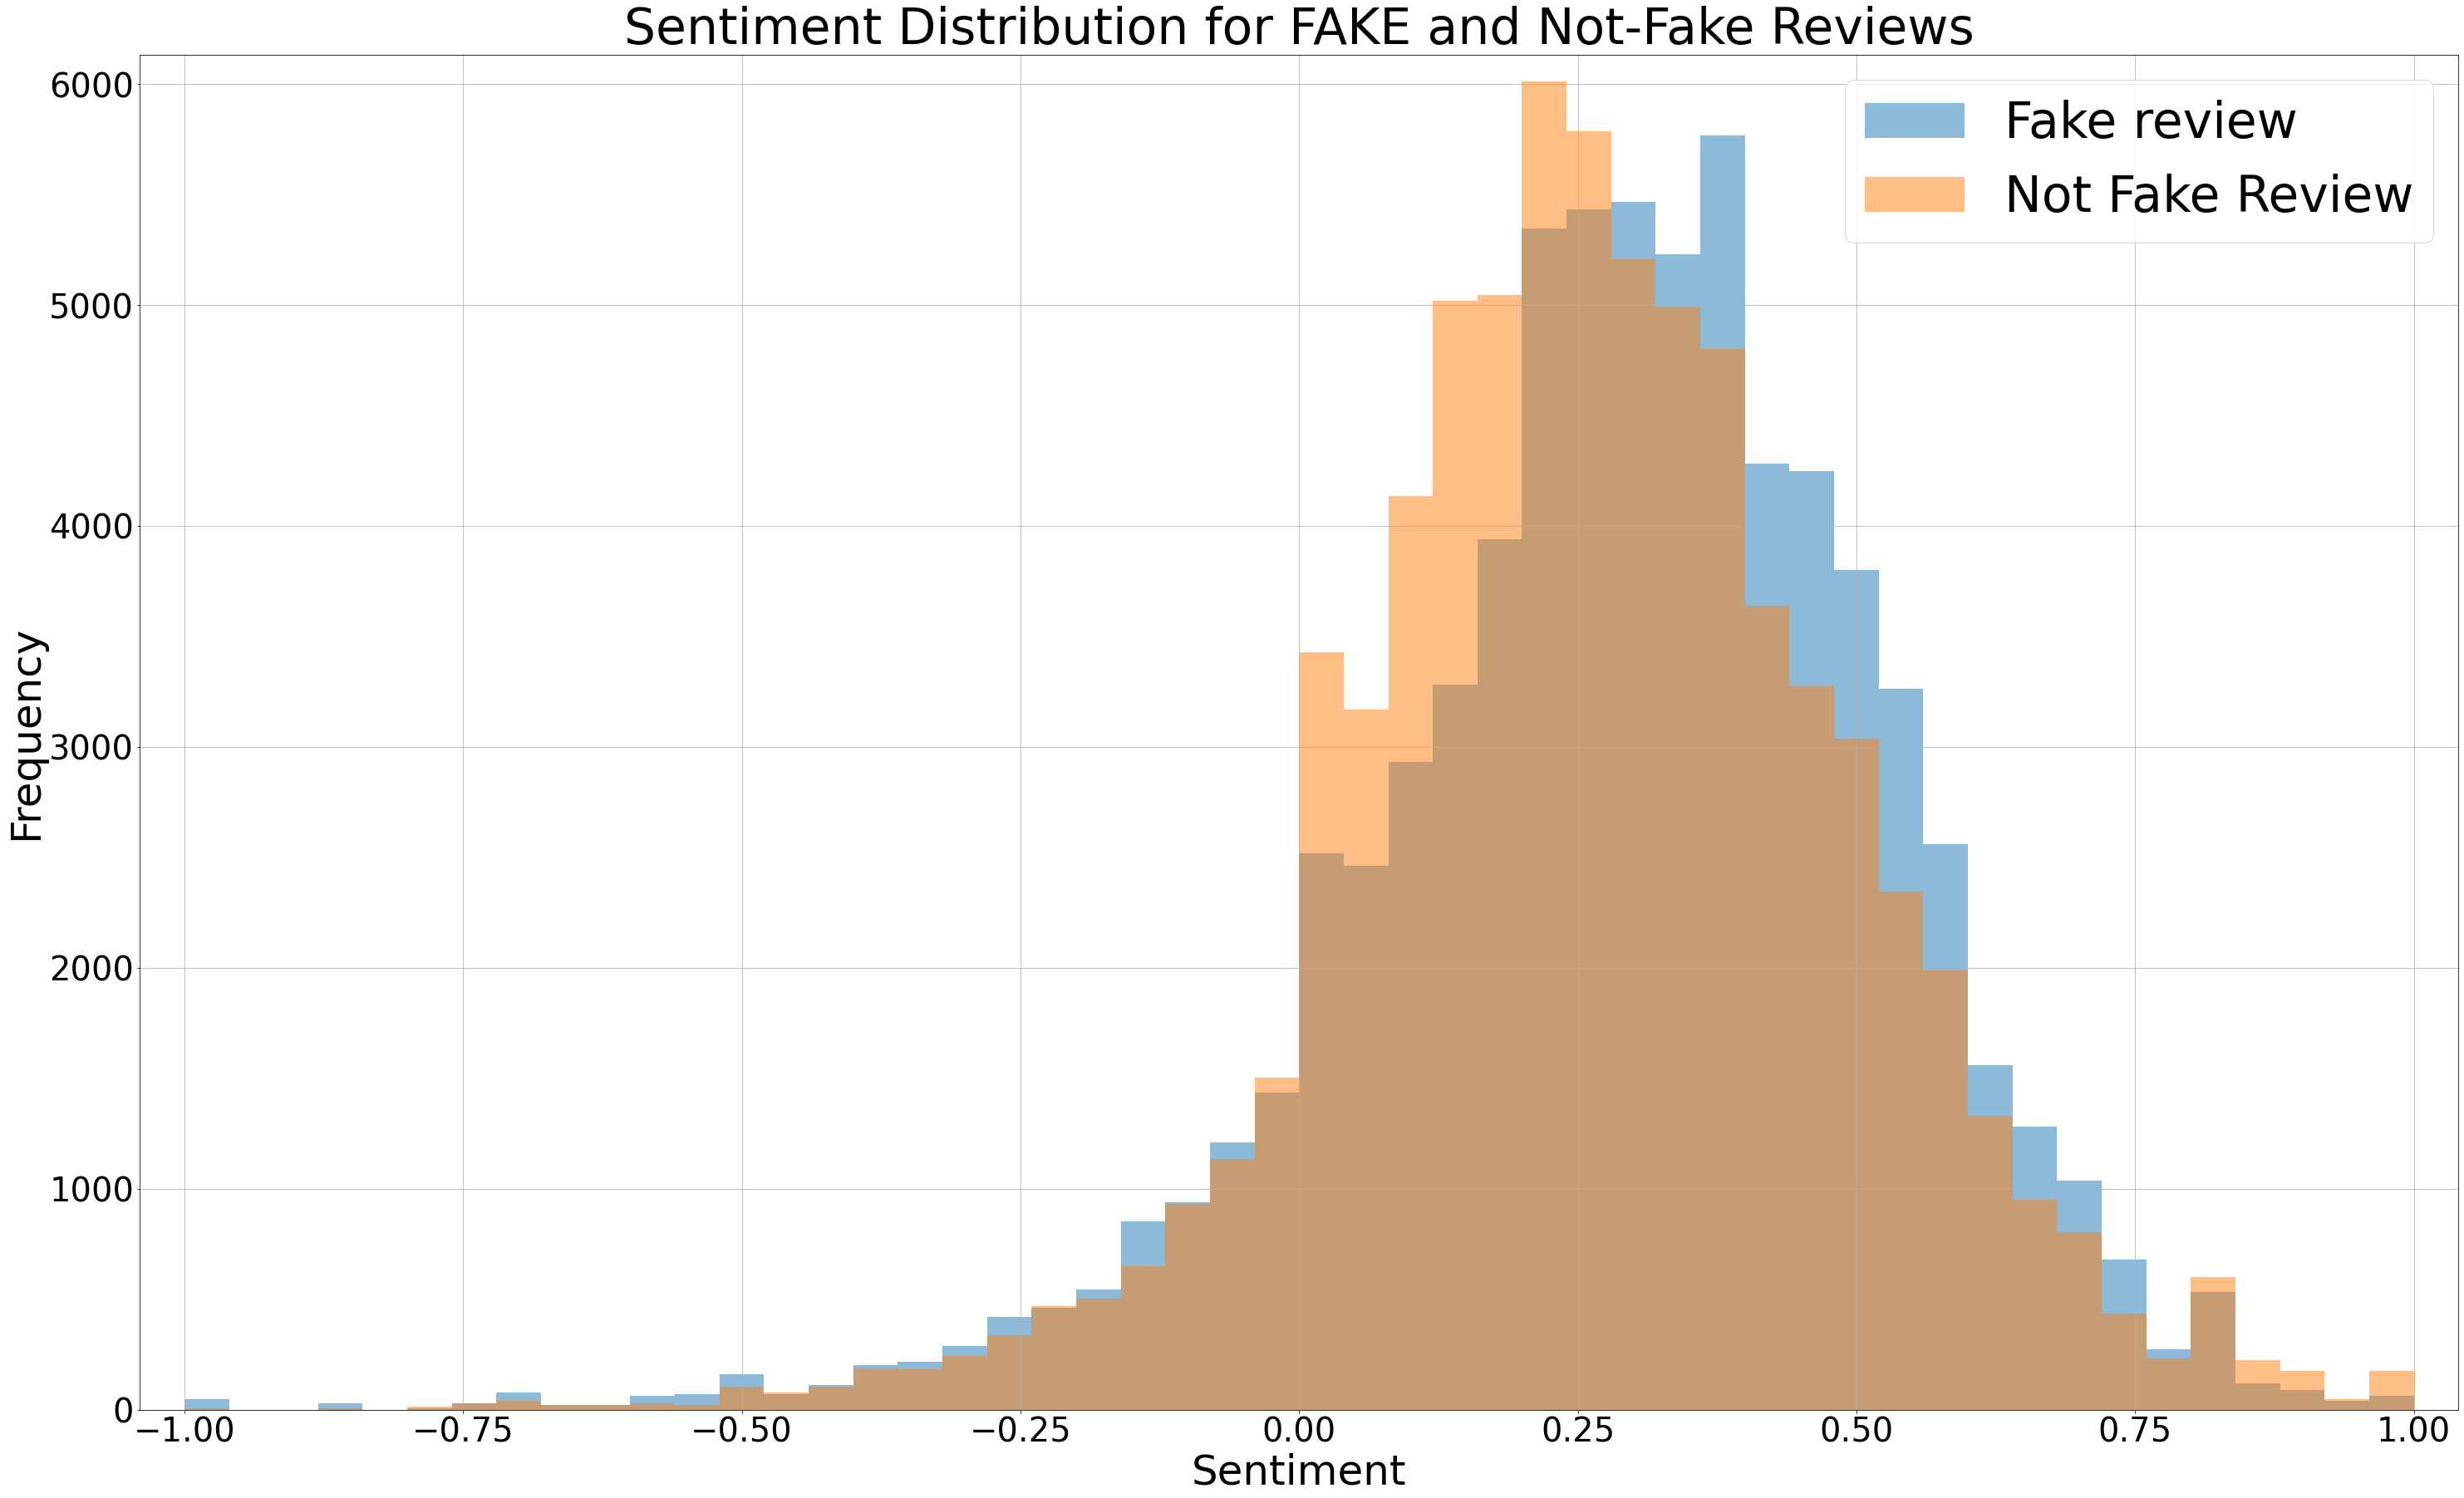

In [32]:
# histogram sentiment distribution for FAKE and Non-Fake reviews

fd = df[df['Label'] == 'Fake']
td= df[df['Label'] == 'Not Fake']
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(fd['sentiment'], bins=50, label='Fake review', alpha=0.5)
plt.hist(td['sentiment'], bins=50, label = 'Not Fake Review', alpha=0.5)
plt.title('Sentiment Distribution for FAKE and Not-Fake Reviews', fontsize=60)
plt.grid()
plt.legend(fontsize=60)
plt.show()

In [33]:
# finding wordcount of reviews

df['word_count'] = df['lemmatized'].apply(lambda x: len(str(x).split()))
df['review_char_len'] = df['lemmatized_str'].astype(str).apply(len)

In [34]:
# Encoding of string values (Label, verified purchase) into numeric values

le = preprocessing.LabelEncoder()
le.fit(df['Verified_Purchase'].astype(str))
df['Verified_Purchase'] = le.transform(df['Verified_Purchase'].astype(str))

le.fit(df['Label'].astype(str))
df['Label'] = le.transform(df['Label'].astype(str))



In [35]:
df.head()

,Label,Verified_Purchase,Review_Text,no_contract,REVIEW_TEXT_str,tag_removed,accent_removed,number_removed,tokenized,lower,no_punc,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemmatized_str,sentiment,sentiment_category,word_count,review_char_len
0,0,0,"useful When least you think so, this product will save the day. Just keep it around just in case...","[useful, When, least, you, think, so,, this, product, will, save, the, day., Just, keep, it, aro...","useful When least you think so, this product will save the day. Just keep it around just in case...","useful When least you think so, this product will save the day. Just keep it around just in case...","useful When least you think so, this product will save the day. Just keep it around just in case...","useful When least you think so, this product will save the day. Just keep it around just in case...","[useful, When, least, you, think, so, ,, this, product, will, save, the, day, ., Just, keep, it,...","[useful, when, least, you, think, so, ,, this, product, will, save, the, day, ., just, keep, it,...","[useful, when, least, you, think, so, this, product, will, save, the, day, just, keep, it, aroun...","[useful, least, think, product, save, day, keep, around, case, need, something]","[(useful, JJ), (least, JJS), (think, JJ), (product, NN), (save, VB), (day, NN), (keep, VB), (aro...","[(useful, a), (least, a), (think, a), (product, n), (save, v), (day, n), (keep, v), (around, n),...","[useful, least, think, product, save, day, keep, around, case, need, something]",useful least think product save day keep around case need something,0.000000,3,11,67
1,0,1,New era for batteries Lithium batteries are something new introduced in the market there average...,"[New, era, for, batteries, Lithium, batteries, are, something, new, introduced, in, the, market,...",New era for batteries Lithium batteries are something new introduced in the market there average...,New era for batteries Lithium batteries are something new introduced in the market there average...,New era for batteries Lithium batteries are something new introduced in the market there average...,New era for batteries Lithium batteries are something new introduced in the market there average...,"[New, era, for, batteries, Lithium, batteries, are, something, new, introduced, in, the, market,...","[new, era, for, batteries, lithium, batteries, are, something, new, introduced, in, the, market,...","[new, era, for, batteries, lithium, batteries, are, something, new, introduced, in, the, market,...","[new, era, batteries, lithium, batteries, something, new, introduced, market, average, developin...","[(new, JJ), (era, NN), (batteries, NNS), (lithium, VBP), (batteries, NNS), (something, NN), (new...","[(new, a), (era, n), (batteries, n), (lithium, v), (batteries, n), (something, n), (new, a), (in...","[new, era, battery, lithium, battery, something, new, introduced, market, average, develop, cost...",new era battery lithium battery something new introduced market average develop cost relatively ...,0.210939,4,43,286
2,0,0,doesn't swing very well. I purchased this swing for my baby. She is 6 months now and has pretty ...,"[does not, swing, very, well., I, purchased, this, swing, for, my, baby., She, is, 6, months, no...",does not swing very well. I purchased this swing for my baby. She is 6 months now and has pretty...,does not swing very well. I purchased this swing for my baby. She is 6 months now and has pretty...,does not swing very well. I purchased this swing for my baby. She is 6 months now and has pretty...,does not swing very well. I purchased this swing for my baby. She is months now and has pretty ...,"[does, not, swing, very, well, ., I, purchased, this, swing, for, my, baby, ., She, is, months, ...","[does, not, swing, very, well, ., i, purchased, this, swing, for, my, baby, ., she, is, months, ...","[does, not, swing, very, well, i, purchased, this, swing, for, my, baby, she, is, months, now, a...","[swing, well, pur

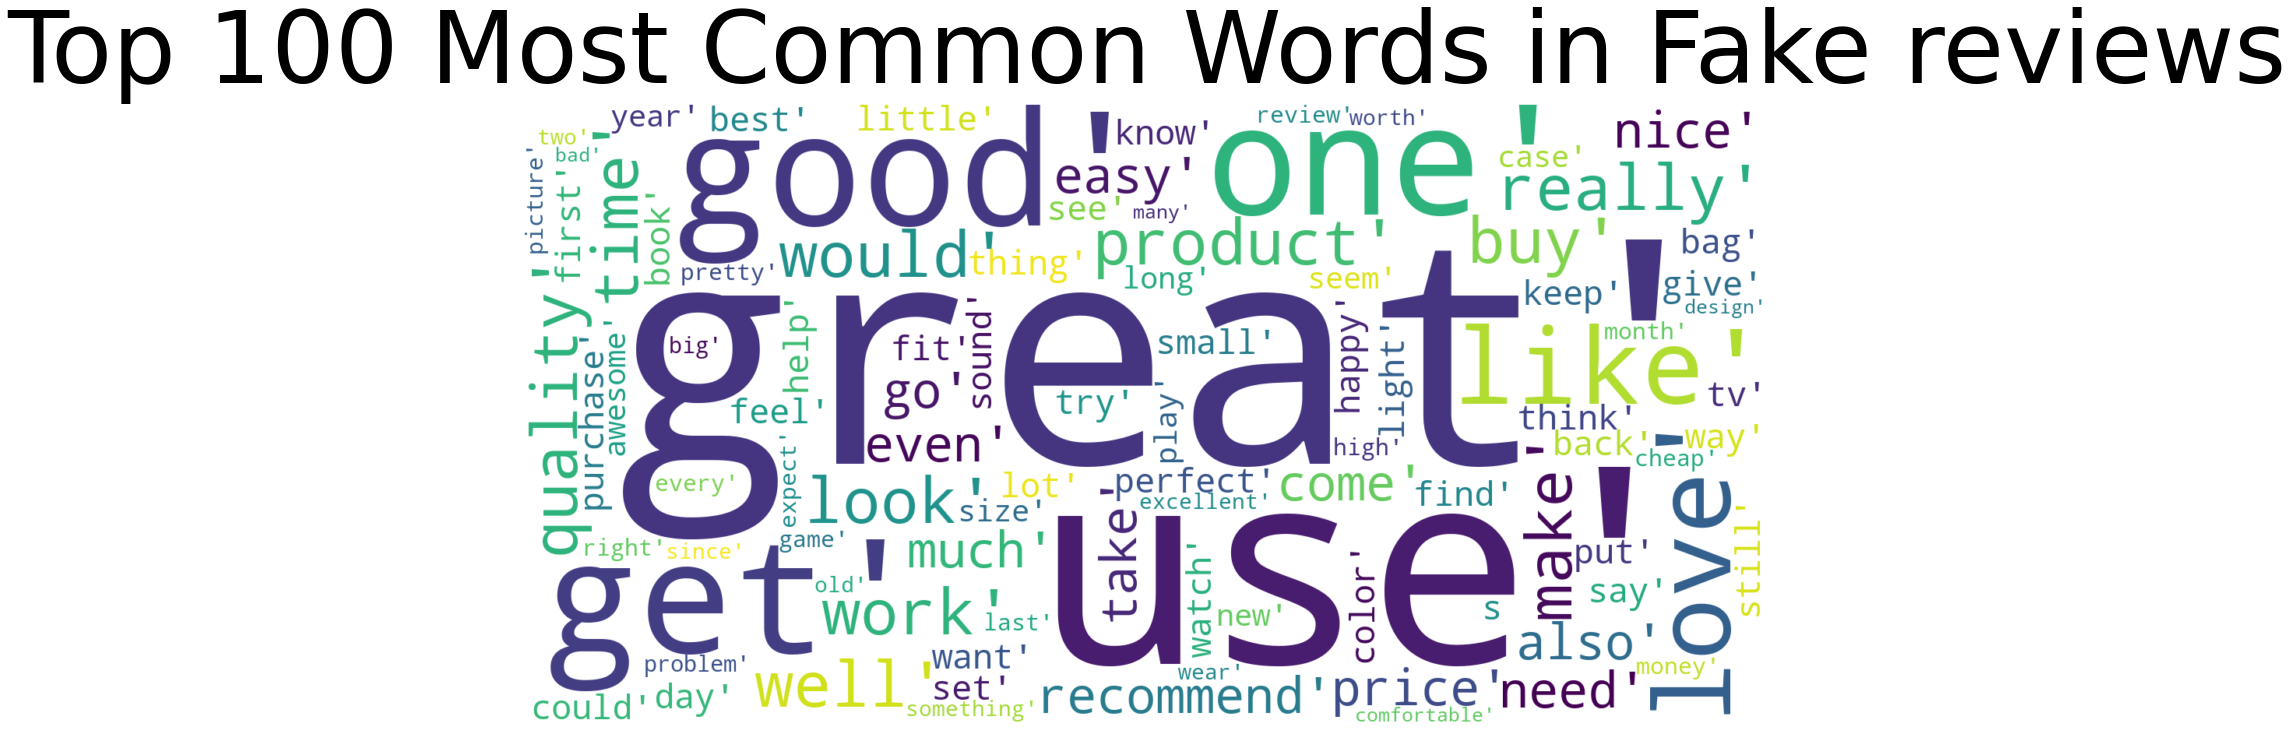

In [36]:
wordsfd = fd['lemmatized']
allwordsfd = []
for wordlist in wordsfd:
    allwordsfd += wordlist

mostcommon = FreqDist(allwordsfd).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words in Fake reviews', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

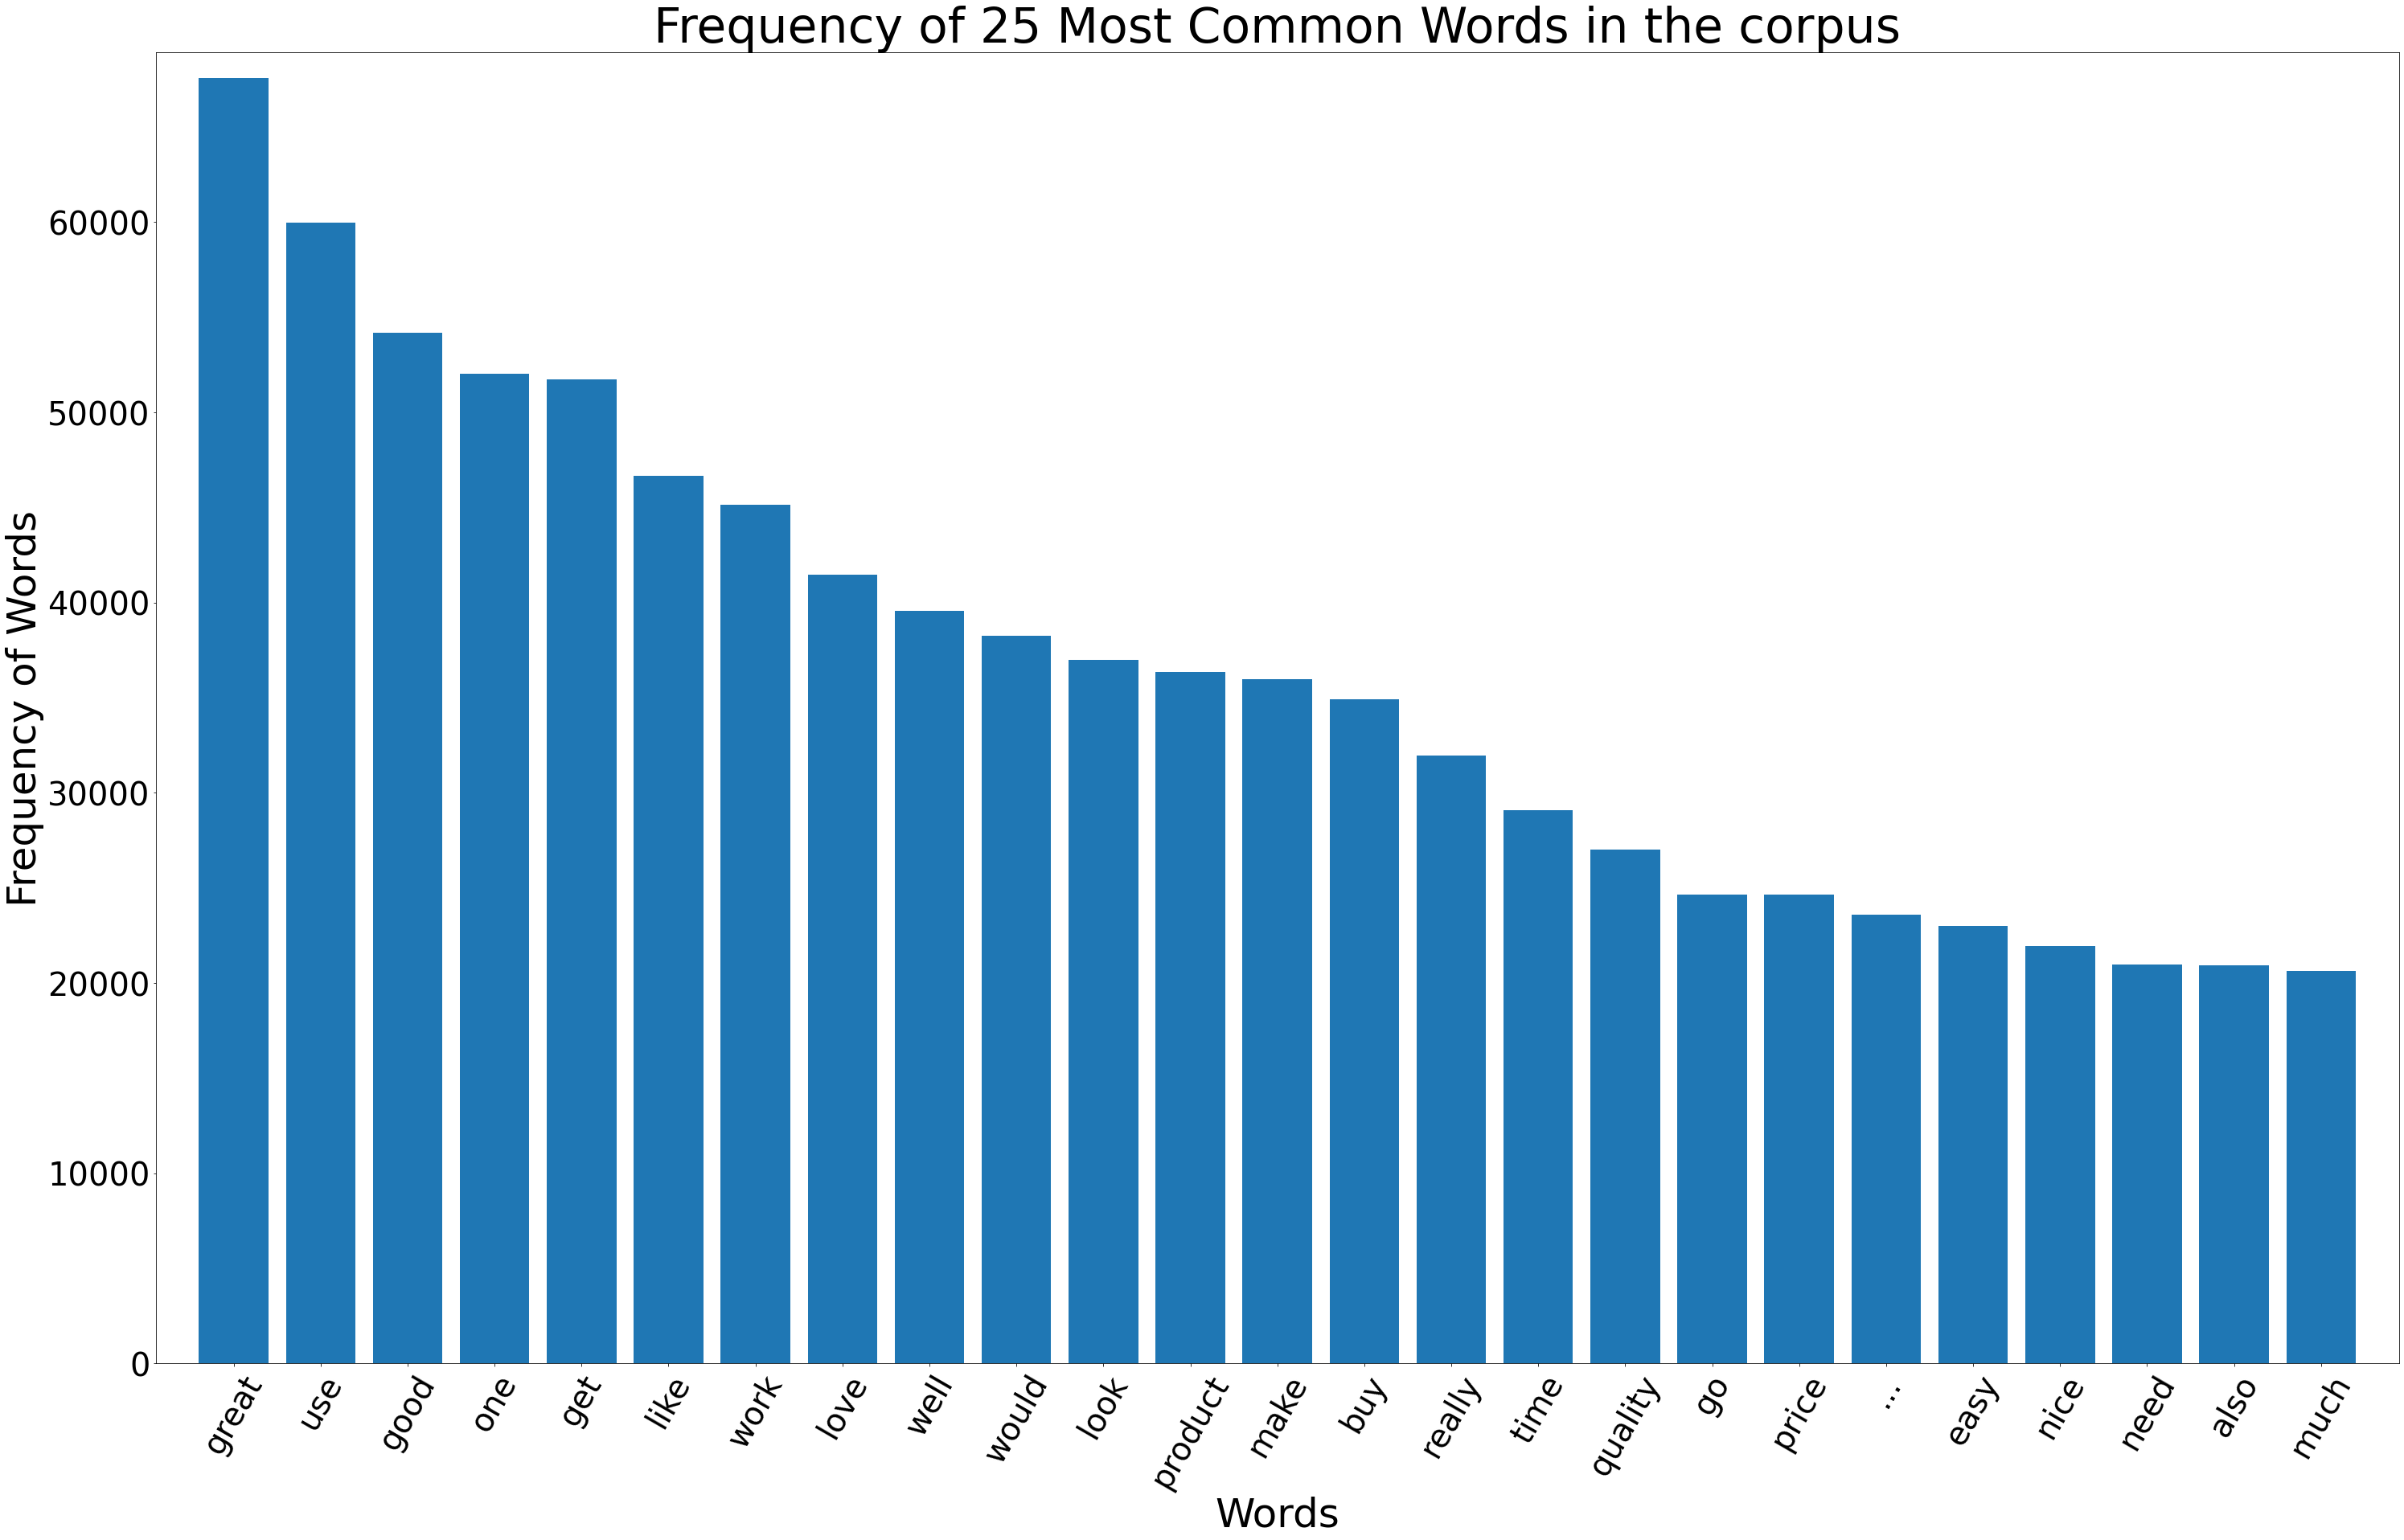

In [37]:
words = df['lemmatized']
allwords = []
for wordlist in words:
    allwords += wordlist

mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words in the corpus', fontsize=60)
plt.show()

# Converting text into machine readable form
Text needs to be converted into machine readable form which is numerical or vectorized form in order to train the machine learning model. Here we explore two methods of doing that - 1) CountVectorizer ; 2) TF-IDF (Term Frequency- Inverse Document Frequency)

In [38]:
# max_df = 0.9 removes words that appear in 90% of documents and min_df removes words that appear in less than 50 documents
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=45, max_features=5000)   
tf = tf_vectorizer.fit_transform(df['lemmatized_str'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix

/Users/fayazmoqueem/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aa,aaa,ab,ability,able,absolute,absolutely,absorb,absorbent,absorbs,...,yrs,yum,yummy,zero,zinc,zip,zipper,zombie,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146988,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
146989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
146990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
146991,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# TF-IDF
This calculates the statistical measure reflecting weight/impact of each word

In [39]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.80, min_df =50, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(df['lemmatized_str'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf

/Users/fayazmoqueem/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aa,aaa,ab,ability,able,absolute,absolutely,absorb,absorbent,absorbs,...,yrs,yum,yummy,zero,zinc,zip,zipper,zombie,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Topic Modeling
Topic Modeling
Topic Modeling will try to derive different themes from the reviews and map each document to one of the theme. We will try to achieve this by two methods: 1) Latent Drichlet Allocation (LDA); 2) Non Negatve Matrix Factorization

In [40]:
# Latent Drichlet Allocation

lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=50, random_state=0).fit(tf)
no_top_words = 10

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])) 
        
        
        
        
display_topics(lda_model, tf_feature_names, no_top_words) 


Topic 0:
game book piece read make set together fun story cover
Topic 1:
get watch time good use one great play like tv
Topic 2:
great use easy product well work make love bag size
Topic 3:
work use one light product buy great sound get well
Topic 4:
dog may cut show film idea test thank disappoint way
Topic 5:
love like great look really buy make color one gift
Topic 6:
store system box include package run card remote cat update
Topic 7:
case phone water one quickly plastic glass like side top
Topic 8:
good quality look price nice picture camera expect screen feature
Topic 9:
get would time wear one battery go day item back


In [42]:
pyLDAvis.enable_notebook()
#panel = pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer, mds='tsne')
#panel

In [43]:
nmf = NMF(n_components=10, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names, no_top_words)

/Users/fayazmoqueem/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


Topic 0:
one get like would go buy make really time look
Topic 1:
watch look movie nice band wrist time wear face like
Topic 2:
good quality price nice sound look high expect really well
Topic 3:
love perfect gift color buy beautiful daughter son absolutely wear
Topic 4:
great price look sound fit buy value recommend deal quality
Topic 5:
product recommend excellent happy highly would awesome skin hair buy
Topic 6:
game play fun kid movie old graphic year son enjoy
Topic 7:
bag size fit nice carry pocket small leather travel perfect
Topic 8:
work well battery fine charge perfectly problem cable need charger
Topic 9:
use easy light clean set also make time camera nice


/Users/fayazmoqueem/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [44]:
# Mapping both nmf and lda topics to a logical topic name

nmf_topic_values = nmf.transform(tfidf)
df['nmf_topics'] = nmf_topic_values.argmax(axis=1)
lda_topic_values = lda_model.transform(tf)
df['lda_topics'] = lda_topic_values.argmax(axis=1)
lda_remap = {0: 'Good Product', 1: 'Good Fit', 2: 'light and comfortable', 3: 'battery/Phone/tool', 4: 'Easy to use', 5: 'great buy', 6: 'good find', 7: 'tv/screen/video', 8: 'book/read/story', 9: 'good price'}
df['lda_topics'] = df['lda_topics'].map(lda_remap)
nmf_remap = {0: 'Buy/time', 1: 'beautiful/gift/color/cute', 2: 'Value for Price', 3: 'Good quality/Price', 4: 'Movie/Nice look', 5: 'Recommend Product', 6: 'Graphics/Games', 7: 'light/battery/charge', 8: 'Fit/good look/size', 9: 'Book/Story'}
df['nmf_topics'] = df['nmf_topics'].map(nmf_remap)

/Users/fayazmoqueem/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


In [45]:
df.head()

,Label,Verified_Purchase,Review_Text,no_contract,REVIEW_TEXT_str,tag_removed,accent_removed,number_removed,tokenized,lower,...,pos_tags,wordnet_pos,lemmatized,lemmatized_str,sentiment,sentiment_category,word_count,review_char_len,nmf_topics,lda_topics
0,0,0,"useful When least you think so, this product will save the day. Just keep it around just in case...","[useful, When, least, you, think, so,, this, product, will, save, the, day., Just, keep, it, aro...","useful When least you think so, this product will save the day. Just keep it around just in case...","useful When least you think so, this product will save the day. Just keep it around just in case...","useful When least you think so, this product will save the day. Just keep it around just in case...","useful When least you think so, this product will save the day. Just keep it around just in case...","[useful, When, least, you, think, so, ,, this, product, will, save, the, day, ., Just, keep, it,...","[useful, when, least, you, think, so, ,, this, product, will, save, the, day, ., just, keep, it,...",...,"[(useful, JJ), (least, JJS), (think, JJ), (product, NN), (save, VB), (day, NN), (keep, VB), (aro...","[(useful, a), (least, a), (think, a), (product, n), (save, v), (day, n), (keep, v), (around, n),...","[useful, least, think, product, save, day, keep, around, case, need, something]",useful least think product save day keep around case need something,0.000000,3,11,67,Recommend Product,good price
1,0,1,New era for batteries Lithium batteries are something new introduced in the market there average...,"[New, era, for, batteries, Lithium, batteries, are, something, new, introduced, in, the, market,...",New era for batteries Lithium batteries are something new introduced in the market there average...,New era for batteries Lithium batteries are something new introduced in the market there average...,New era for batteries Lithium batteries are something new introduced in the market there average...,New era for batteries Lithium batteries are something new introduced in the market there average...,"[New, era, for, batteries, Lithium, batteries, are, something, new, introduced, in, the, market,...","[new, era, for, batteries, lithium, batteries, are, something, new, introduced, in, the, market,...",...,"[(new, JJ), (era, NN), (batteries, NNS), (lithium, VBP), (batteries, NNS), (something, NN), (new...","[(new, a), (era, n), (batteries, n), (lithium, v), (batteries, n), (something, n), (new, a), (in...","[new, era, battery, lithium, battery, something, new, introduced, market, average, develop, cost...",new era battery lithium battery something new introduced market average develop cost relatively ...,0.210939,4,43,286,Fit/good look/size,good price
2,0,0,doesn't swing very well. I purchased this swing for my baby. She is 6 months now and has pretty ...,"[does not, swing, very, well., I, purchased, this, swing, for, my, baby., She, is, 6, months, no...",does not swing very well. I purchased this swing for my baby. She is 6 months now and has pretty...,does not swing very well. I purchased this swing for my baby. She is 6 months now and has pretty...,does not swing very well. I purchased this swing for my baby. She is 6 months now and has pretty...,does not swing very well. I purchased this swing for my baby. She is months now and has pretty ...,"[does, not, swing, very, well, ., I, purchased, this, swing, for, my, baby, ., She, is, months, ...","[does, not, swing, very, well, ., i, purchased, this, swing, for, my, baby, ., she, is, months, ...",...,"[(swing, VBG), (well, RB), (purchased, VBN), (swing, VBG), (baby, JJ), (months, NNS), (pretty, R...","[(swing, v), (well, r), (purchased, v), (swing, v), (baby, a), (months, n), (pretty, r), (much, ...","[swing, well, purchase, swing, baby, month, pretty, much, grow, loud, swing, well, beautiful, th...",swing well purchase swing baby month pretty much grow loud swing well beautiful though love colo...,0.366667,4,21,127,Good quality/

/Users/fayazmoqueem/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.,
        40000., 45000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

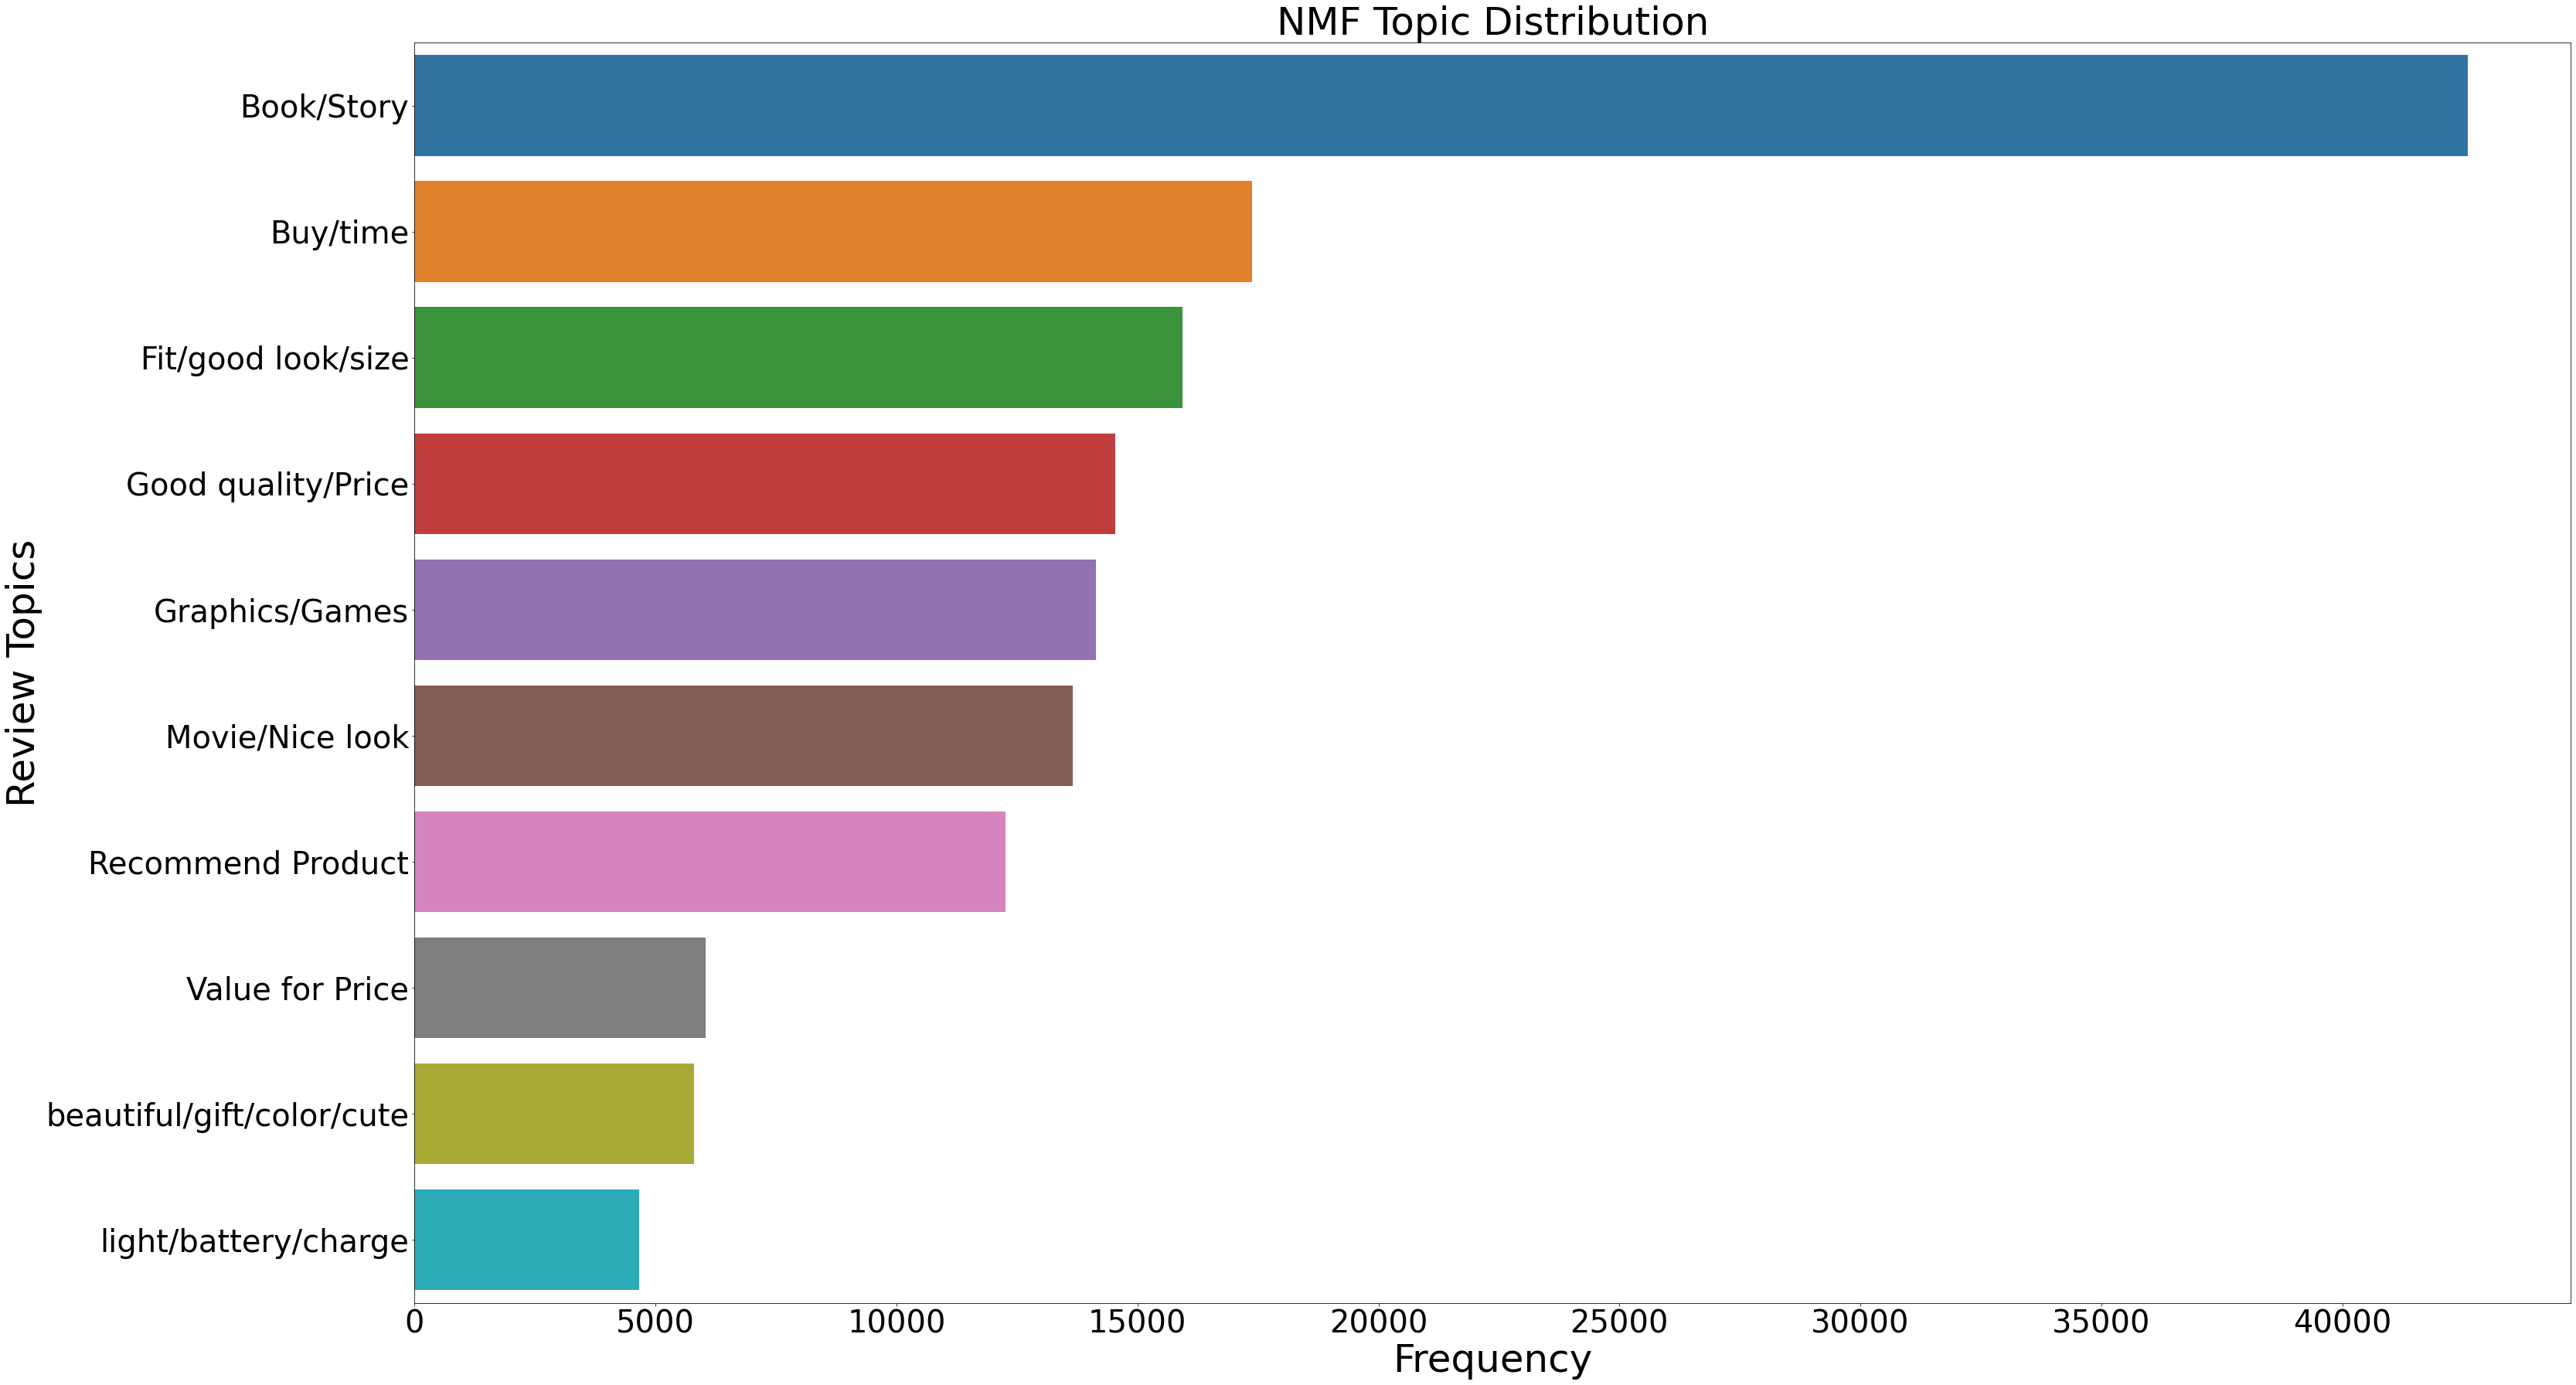

In [46]:
nmf_x = df['nmf_topics'].value_counts()
nmf_y = nmf_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_x, nmf_y.index)
plt.title("NMF Topic Distribution", fontsize=50)
plt.ylabel('Review Topics', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Frequency', fontsize=50)
plt.xticks(fontsize=40)

/Users/fayazmoqueem/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([    0., 10000., 20000., 30000., 40000., 50000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

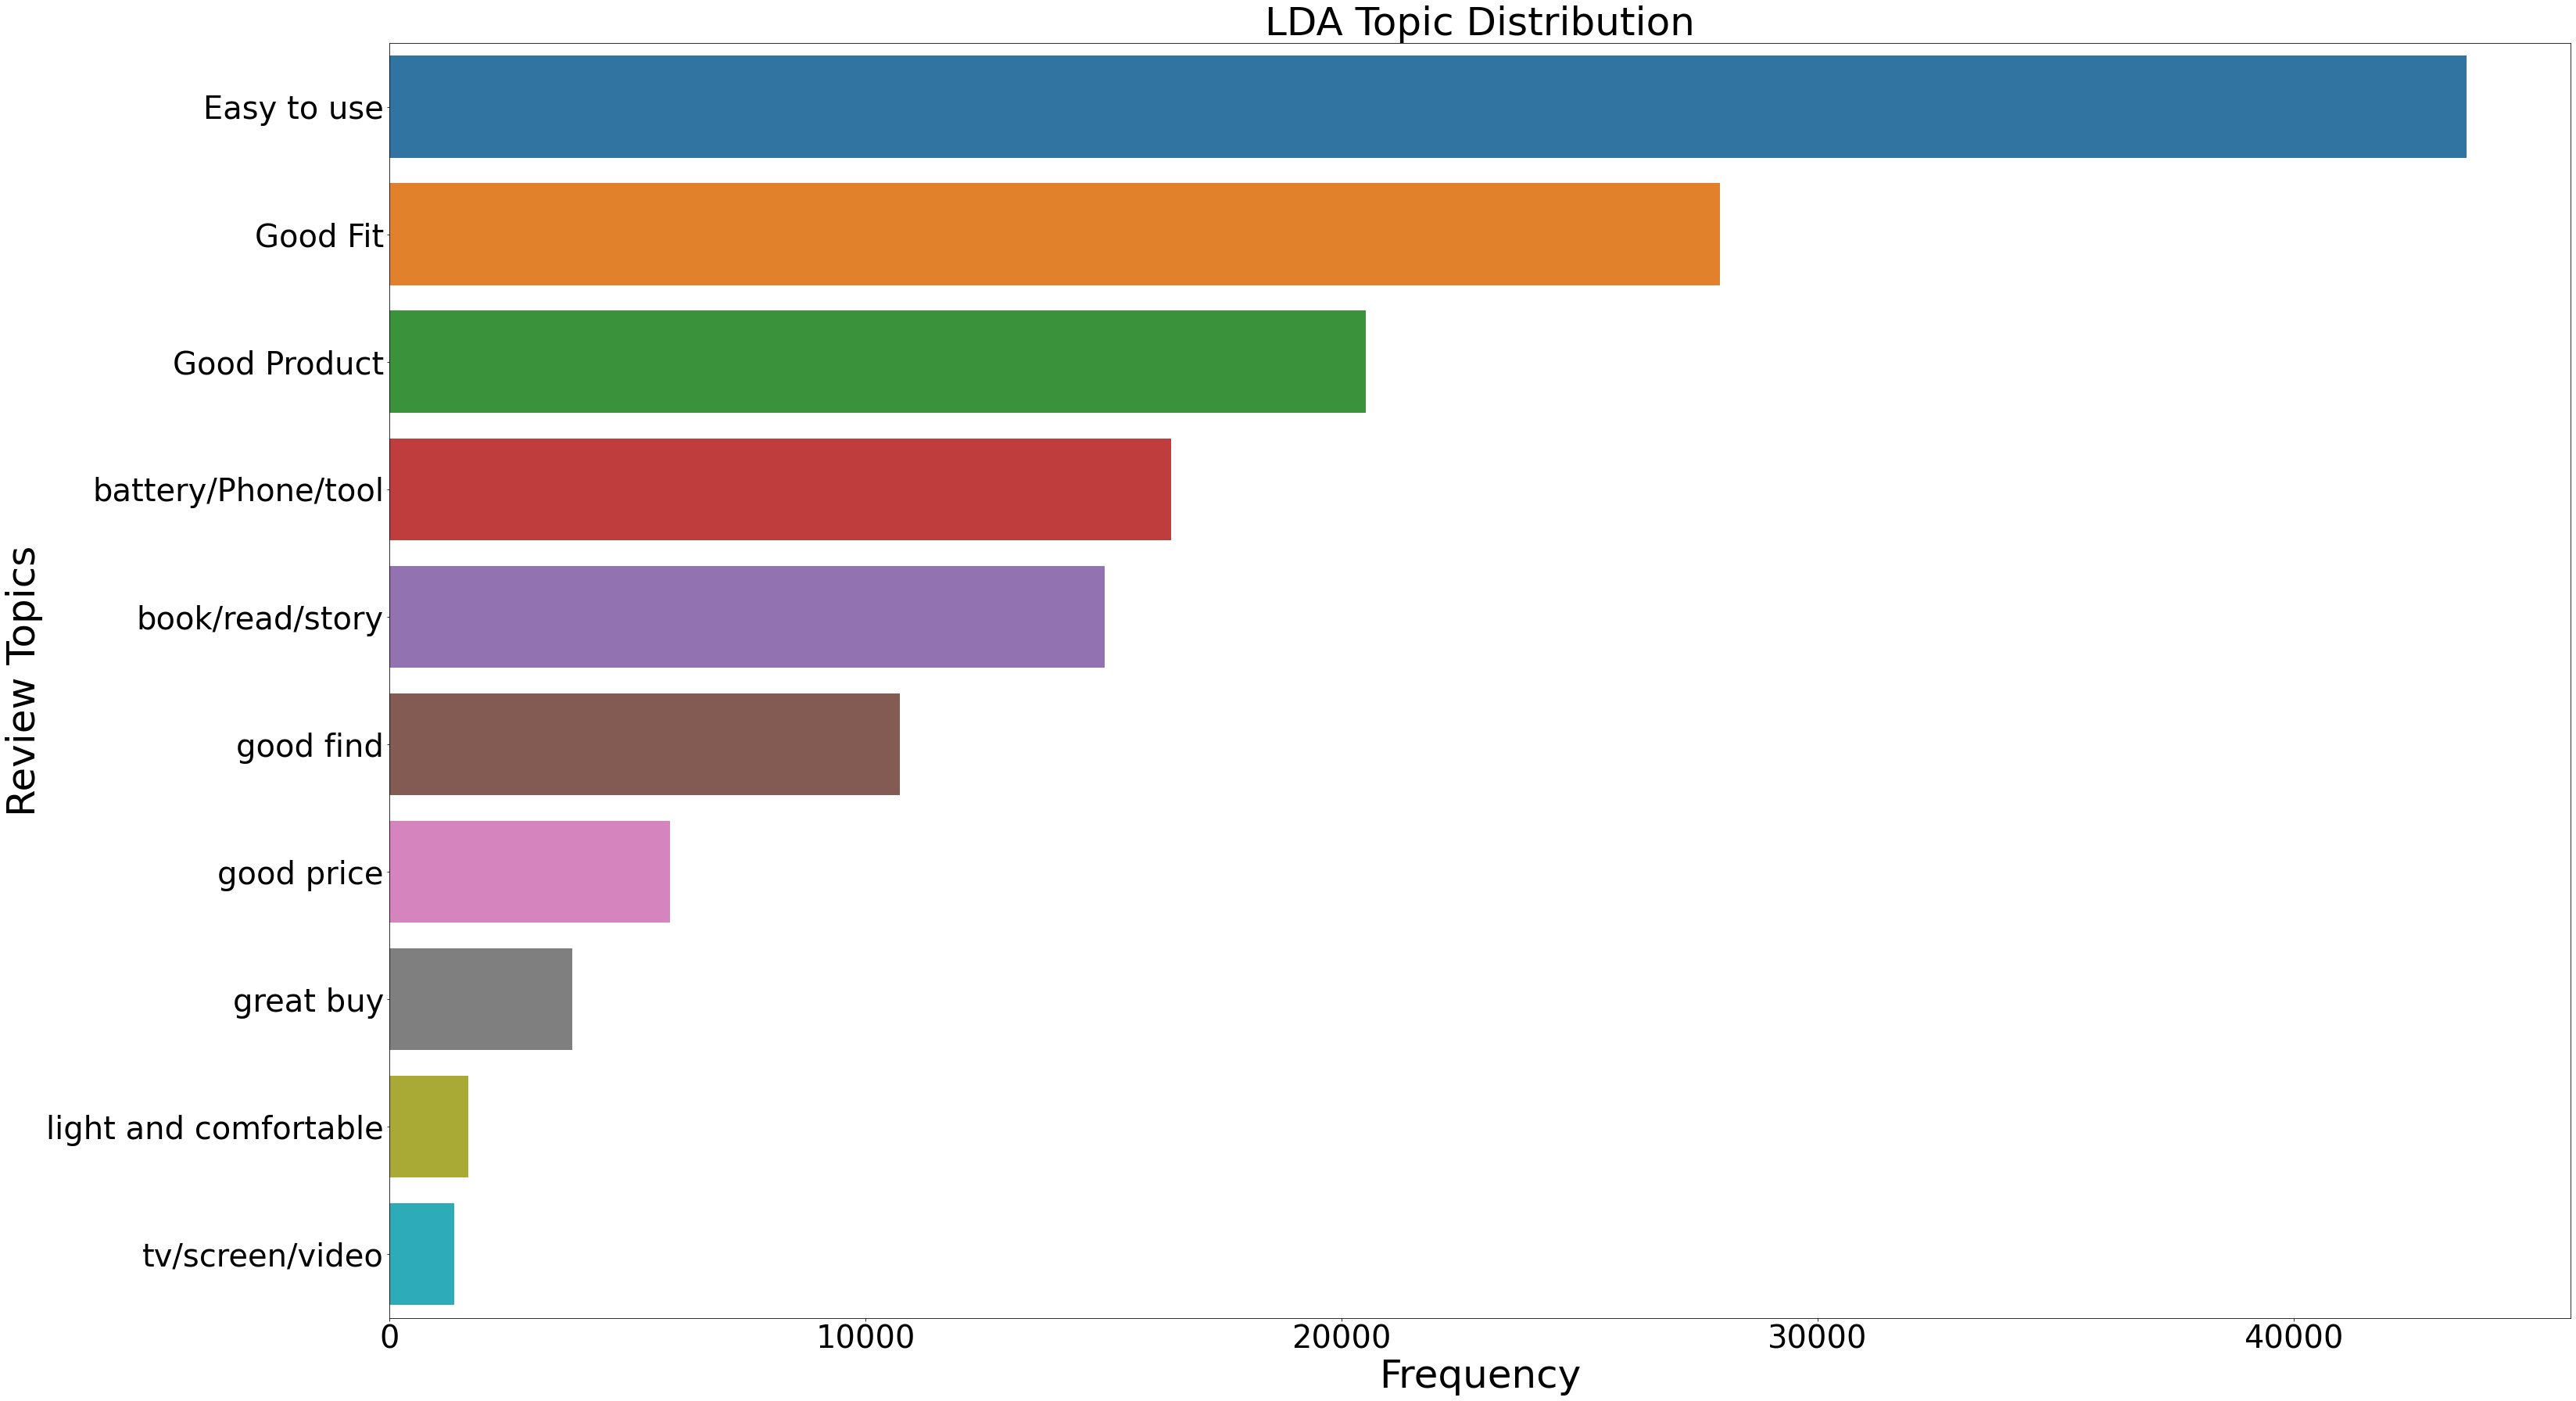

In [47]:
lda_x = df['lda_topics'].value_counts()
lda_y = lda_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(lda_x, lda_y.index)
plt.title("LDA Topic Distribution", fontsize=50)
plt.ylabel('Review Topics', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Frequency', fontsize=50)
plt.xticks(fontsize=40)

# Comparison of different Machine Learning Classification model to predict False reviews based on review sentiment
According to correlation, it has been identified that some of the differentiating features in predicting Fake reviews is Verified Purchase, Review character length and sentiment. I would like to train models based on these features and check the accuracy levels.

In [48]:
dataframe = df[['sentiment_category','review_char_len','Verified_Purchase','Label']]
array = dataframe.values
X = array[:,0:3]
Y = array[:,3]                 


In [49]:

# Define dictionary with performance metrics
scoring = {'accuracy':make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score),
           'recall':make_scorer(recall_score), 
           'f1_score':make_scorer(f1_score)}



# Instantiate the machine learning classifiers
log_model = LogisticRegression(max_iter=10000)
svc_model = LinearSVC(dual=False)
dtr_model = DecisionTreeClassifier()

rfc_model = RandomForestClassifier()
gnb_model = GaussianNB()
knn_model = KNeighborsClassifier()
lda_model = LinearDiscriminantAnalysis()

# Define the models evaluation function
def models_evaluation(X, y, folds):
    
    '''
    X : data set features
    y : data set target
    folds : number of cross-validation folds
    
    '''
    
    # Perform cross-validation to each machine learning classifier
    log = cross_validate(log_model, X, y, cv=folds, scoring=scoring)
    svc = cross_validate(svc_model, X, y, cv=folds, scoring=scoring)
    dtr = cross_validate(dtr_model, X, y, cv=folds, scoring=scoring)
    rfc = cross_validate(rfc_model, X, y, cv=folds, scoring=scoring)
    gnb = cross_validate(gnb_model, X, y, cv=folds, scoring=scoring)
    knn = cross_validate(knn_model, X, y, cv=folds, scoring=scoring)
    lda = cross_validate(lda_model, X, y, cv=folds, scoring=scoring)

    # Create a data frame with the models perfoamnce metrics scores
    models_scores_table = pd.DataFrame({'Logistic Regression':[log['test_accuracy'].mean(),
                                                               log['test_precision'].mean(),
                                                               log['test_recall'].mean(),
                                                               log['test_f1_score'].mean()],
                                       
                                      'Support Vector Classifier':[svc['test_accuracy'].mean(),
                                                                   svc['test_precision'].mean(),
                                                                   svc['test_recall'].mean(),
                                                                   svc['test_f1_score'].mean()],
                                       
                                      'Decision Tree':[dtr['test_accuracy'].mean(),
                                                       dtr['test_precision'].mean(),
                                                       dtr['test_recall'].mean(),
                                                       dtr['test_f1_score'].mean()],
                                       
                                      'Random Forest':[rfc['test_accuracy'].mean(),
                                                       rfc['test_precision'].mean(),
                                                       rfc['test_recall'].mean(),
                                                       rfc['test_f1_score'].mean()],
                                       
                                      'Gaussian Naive Bayes':[gnb['test_accuracy'].mean(),
                                                              gnb['test_precision'].mean(),
                                                              gnb['test_recall'].mean(),
                                                              gnb['test_f1_score'].mean()],
                                       
                                       'KNeighbours':[knn['test_accuracy'].mean(),
                                                              knn['test_precision'].mean(),
                                                              knn['test_recall'].mean(),
                                                              knn['test_f1_score'].mean()],
                                       
                                       'Latent Drichlet Analysis':[lda['test_accuracy'].mean(),
                                                              lda['test_precision'].mean(),
                                                              lda['test_recall'].mean(),
                                                              lda['test_f1_score'].mean()]},
                                       
                                       
                                      
                                      index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
    
    # Add 'Best Score' column
    models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)
    
    # Return models performance metrics scores data frame
    return(models_scores_table)
  
# Run models_evaluation function
models_evaluation(X, Y, 5)

,Logistic Regression,Support Vector Classifier,Decision Tree,Random Forest,Gaussian Naive Bayes,KNeighbours,Latent Drichlet Analysis,Best Score
Accuracy,0.790160,0.788473,0.823896,0.823937,0.793249,0.699924,0.786541,Random Forest
Precision,0.754213,0.754055,0.787825,0.784560,0.752810,0.858495,0.754153,KNeighbours
Recall,0.861647,0.857007,0.887146,0.893718,0.873988,0.478875,0.851047,Random Forest
F1 Score,0.804184,0.802052,0.834427,0.835475,0.808742,0.614510,0.799483,Random Forest
